# ANSHUMAAN KUMAR PRASAD

**DATA SCIENCE**

Stock Market Prediction using Numerical and Textual Analysis

**PROBLEM** : Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

**DATASET** : 
- Download historical stock prices (^BESN.csv) : (https://finance.yahoo.com/) or https://finance.yahoo.com/quote/%5EBSESN/history?p=%5EBSESN

- Download textual (news) data from https://bit.ly/36fFPI6

**SOLUTION** :- 

In [ ]:
#!pip install pandas_datareader

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# For time stamps
from datetime import datetime

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For sentiments
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# Model Building
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

# Preprocessing & Data Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, metrics

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Fetching and Reading Data

In [ ]:
# The tech companies (Apple, Google, Microsoft, and Amazon) stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Seting up End and Start times for data fetching
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)


#For loop for fetching yahoo finance data and setting as a dataframe
for stock in tech_list:   
    # Seting DataFrame as the Stock Ticker
    globals()[stock] = DataReader(stock, 'yahoo', start, end)

In [ ]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

In [ ]:
df.head(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-02-21,80.112503,77.625000,79.654999,78.262497,129554000.0,77.660507,APPLE
2020-02-24,76.044998,72.307503,74.315002,74.544998,222195200.0,73.971603,APPLE
2020-02-25,75.632500,71.532501,75.237503,72.019997,230673600.0,71.466019,APPLE
2020-02-26,74.470001,71.625000,71.632500,73.162498,198054800.0,72.599739,APPLE
2020-02-27,71.500000,68.239998,70.275002,68.379997,320605600.0,67.854019,APPLE
2020-02-28,69.602501,64.092499,64.315002,68.339996,426884800.0,67.814331,APPLE
2020-03-02,75.360001,69.430000,70.570000,74.702499,341397200.0,74.127892,APPLE
2020-03-03,76.000000,71.449997,75.917503,72.330002,319475600.0,71.773636,APPLE
2020-03-04,75.849998,73.282501,74.110001,75.684998,219178400.0,75.102829,APPLE


In [ ]:
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2021-02-05,3377.000000,3302.709961,3319.000000,3352.149902,3613600.0,3352.149902,AMAZON
2021-02-08,3365.000000,3304.000000,3358.500000,3322.939941,3257400.0,3322.939941,AMAZON
2021-02-09,3338.000000,3297.840088,3312.489990,3305.000000,2203500.0,3305.000000,AMAZON
2021-02-10,3317.949951,3254.000000,3314.000000,3286.580078,3151600.0,3286.580078,AMAZON
2021-02-11,3292.000000,3248.060059,3292.000000,3262.129883,2295800.0,3262.129883,AMAZON
2021-02-12,3280.250000,3233.310059,3250.000000,3277.709961,2329300.0,3277.709961,AMAZON
2021-02-16,3308.300049,3253.590088,3254.050049,3268.949951,2563200.0,3268.949951,AMAZON
2021-02-17,3320.909912,3259.500000,3263.600098,3308.639893,3297500.0,3308.639893,AMAZON
2021-02-18,3338.000000,3273.939941,3282.419922,3328.229980,3027400.0,3328.229980,AMAZON


In [ ]:
# Summary Stats of Apple stocks
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,104.033443,101.017242,102.555090,102.574464,1.540839e+08,102.209524
std,24.341239,23.935627,24.332860,24.128663,7.178746e+07,24.241783
min,57.125000,53.152500,57.020000,56.092499,4.669130e+07,55.661041
25%,79.911875,78.696251,79.186872,79.205002,1.030439e+08,78.808517
50%,112.671249,109.133751,111.340000,111.156250,1.363478e+08,110.799244
75%,123.527500,120.045002,121.464998,121.897499,1.848412e+08,121.715616
max,145.089996,141.369995,143.600006,143.160004,4.268848e+08,142.946396


In [ ]:
# Summary Stats of Google stocks
GOOG.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,1561.157902,1520.870106,1539.633276,1541.714383,1.897563e+06,1541.714383
std,234.256910,236.254430,234.372198,234.927501,7.737233e+05,234.927501
min,1071.319946,1013.536011,1056.510010,1056.619995,3.468000e+05,1056.619995
25%,1418.120026,1385.505005,1398.780029,1403.694977,1.386425e+06,1403.694977
50%,1522.834961,1490.834961,1506.234985,1512.755005,1.666550e+06,1512.755005
75%,1759.360046,1722.422546,1736.112518,1739.685028,2.182150e+06,1739.685028
max,2152.679932,2104.360107,2119.270020,2128.310059,4.329100e+06,2128.310059


In [ ]:
# Summary Stats Microsoft stocks
MSFT.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,203.434365,198.131270,200.750119,200.868928,3.762916e+07,199.706161
std,23.832275,24.920359,24.526042,24.452672,1.712504e+07,24.782232
min,140.570007,132.520004,137.009995,135.419998,1.055060e+07,134.057693
25%,185.629997,182.227501,183.924999,183.384995,2.602250e+07,181.775303
50%,210.784996,205.364998,208.209999,208.250000,3.258630e+07,206.765121
75%,217.382496,213.214996,215.047501,216.215004,4.391550e+07,215.011448
max,246.130005,242.919998,245.029999,244.990005,9.707360e+07,244.427048


In [ ]:
# Summary Stats Amazon stocks
AMZN.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,2889.874355,2810.174801,2851.597423,2850.734993,4.898221e+06,2850.734993
std,497.561771,491.982451,498.982169,492.667556,1.863152e+06,492.667556
min,1759.449951,1626.030029,1641.510010,1676.609985,1.451900e+06,1676.609985
25%,2461.750000,2397.652466,2427.332581,2434.224915,3.509825e+06,2434.224915
50%,3142.344971,3074.074951,3114.594971,3104.224976,4.510950e+06,3104.224976
75%,3247.117493,3165.152527,3209.017456,3205.317505,5.789000e+06,3205.317505
max,3552.250000,3486.689941,3547.000000,3531.449951,1.203820e+07,3531.449951


In [ ]:
# General Apple stocks info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-02-21 to 2021-02-19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          252 non-null    float64
 1   Low           252 non-null    float64
 2   Open          252 non-null    float64
 3   Close         252 non-null    float64
 4   Volume        252 non-null    float64
 5   Adj Close     252 non-null    float64
 6   company_name  252 non-null    object 
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


In [ ]:
# General Google stocks info
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-02-21 to 2021-02-19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          252 non-null    float64
 1   Low           252 non-null    float64
 2   Open          252 non-null    float64
 3   Close         252 non-null    float64
 4   Volume        252 non-null    int64  
 5   Adj Close     252 non-null    float64
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
# General Microsoft stocks info
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-02-21 to 2021-02-19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          252 non-null    float64
 1   Low           252 non-null    float64
 2   Open          252 non-null    float64
 3   Close         252 non-null    float64
 4   Volume        252 non-null    float64
 5   Adj Close     252 non-null    float64
 6   company_name  252 non-null    object 
dtypes: float64(6), object(1)
memory usage: 15.8+ KB


In [ ]:
# General Amazon stocks info
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-02-21 to 2021-02-19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   High          252 non-null    float64
 1   Low           252 non-null    float64
 2   Open          252 non-null    float64
 3   Close         252 non-null    float64
 4   Volume        252 non-null    int64  
 5   Adj Close     252 non-null    float64
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


**Change in price of the all tech companies stocks overtime**

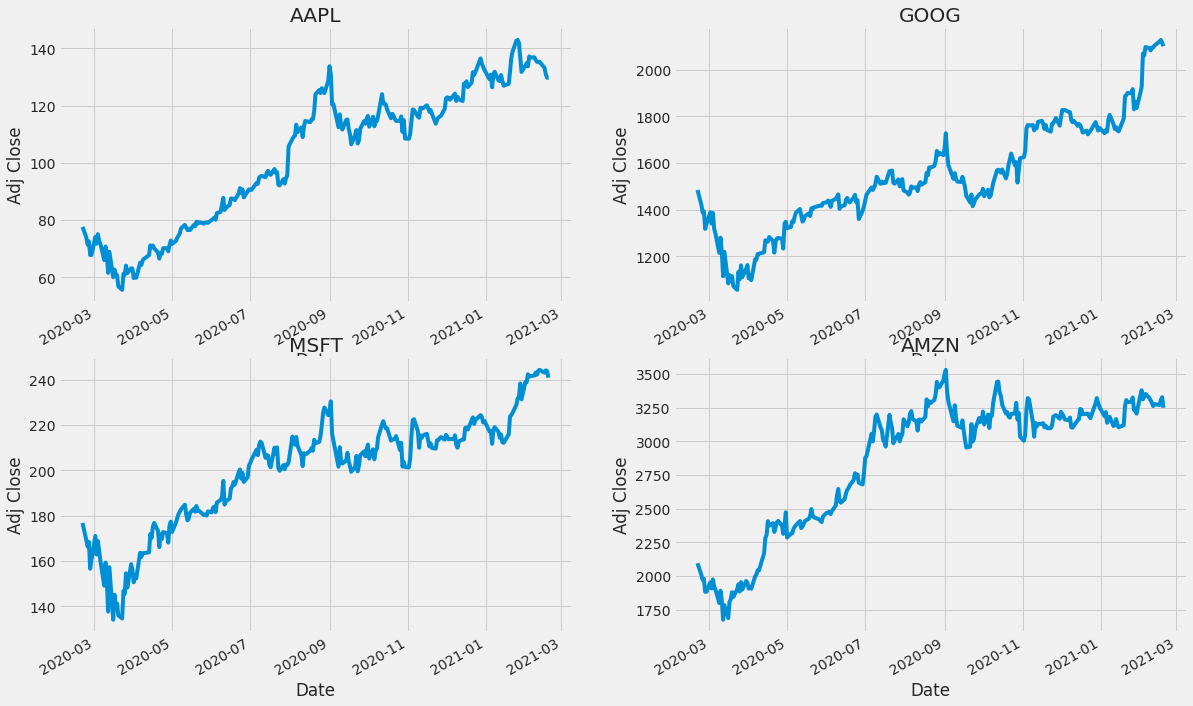

In [ ]:
# Let's see a historical change in the closing price overtime
plt.figure(figsize=(18, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel('Date')
    plt.title(f"{tech_list[i - 1]}")

**The total volume of stock being traded each day :**

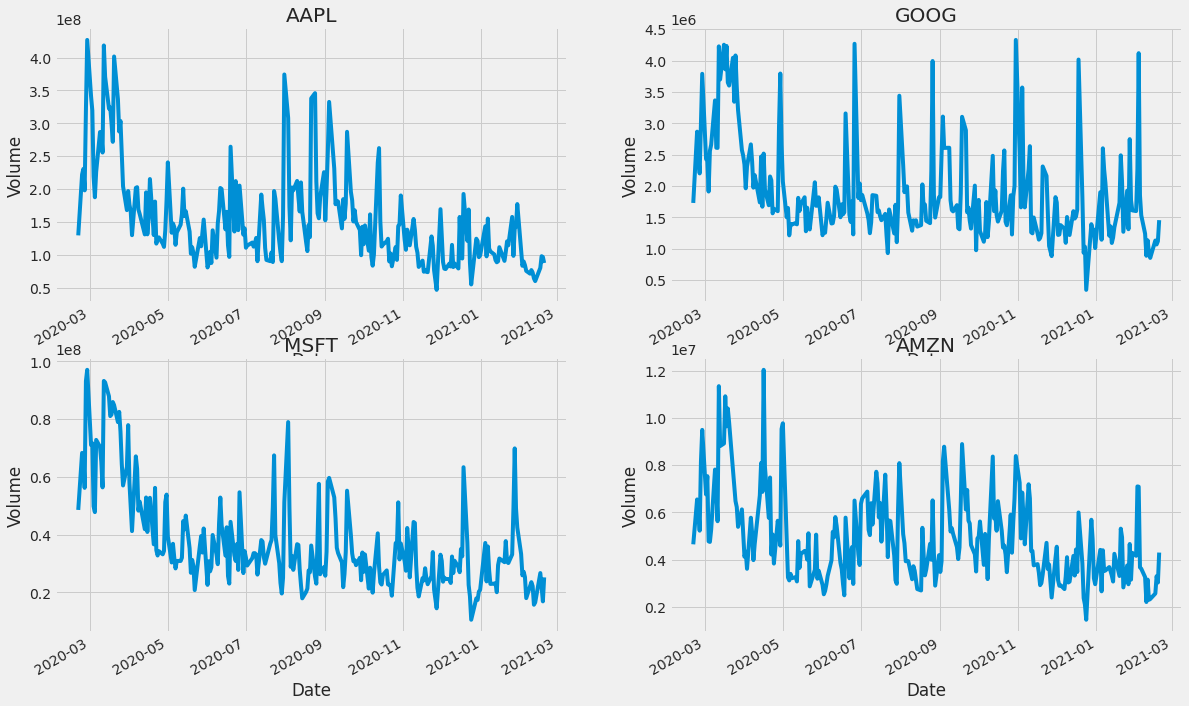

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel("Date")
    plt.title(f"{tech_list[i - 1]}")

**The Max High of stock being traded each day :**

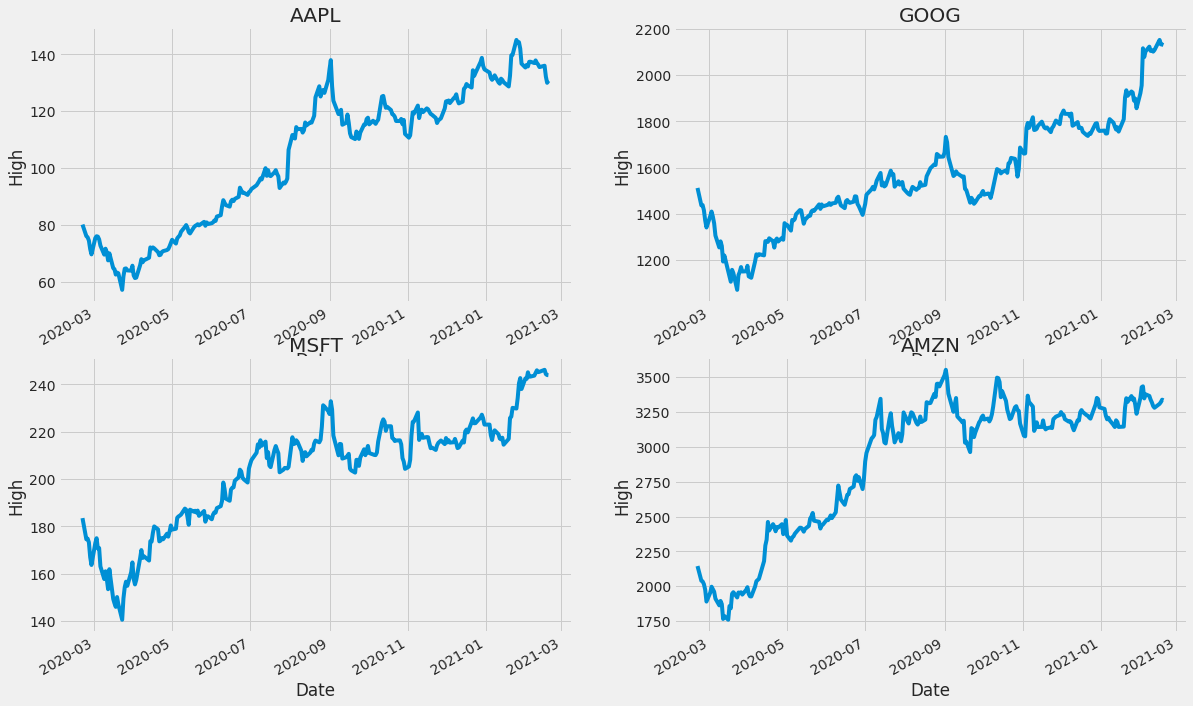

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['High'].plot()
    plt.ylabel('High')
    plt.xlabel("Date")
    plt.title(f"{tech_list[i - 1]}")

**The moving average of the various stocks :**

In [ ]:
moving_avg_day = [10, 20, 50]

for mv_avg in moving_avg_day:
    for company in company_list:
        column_name = f"MA for {mv_avg} days"
        company[column_name] = company['Adj Close'].rolling(mv_avg).mean()

In [ ]:
print(AAPL.columns)
print(' ')
print(GOOG.columns)
print(' ')
print(MSFT.columns)
print(' ')
print(AMZN.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')
 
Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


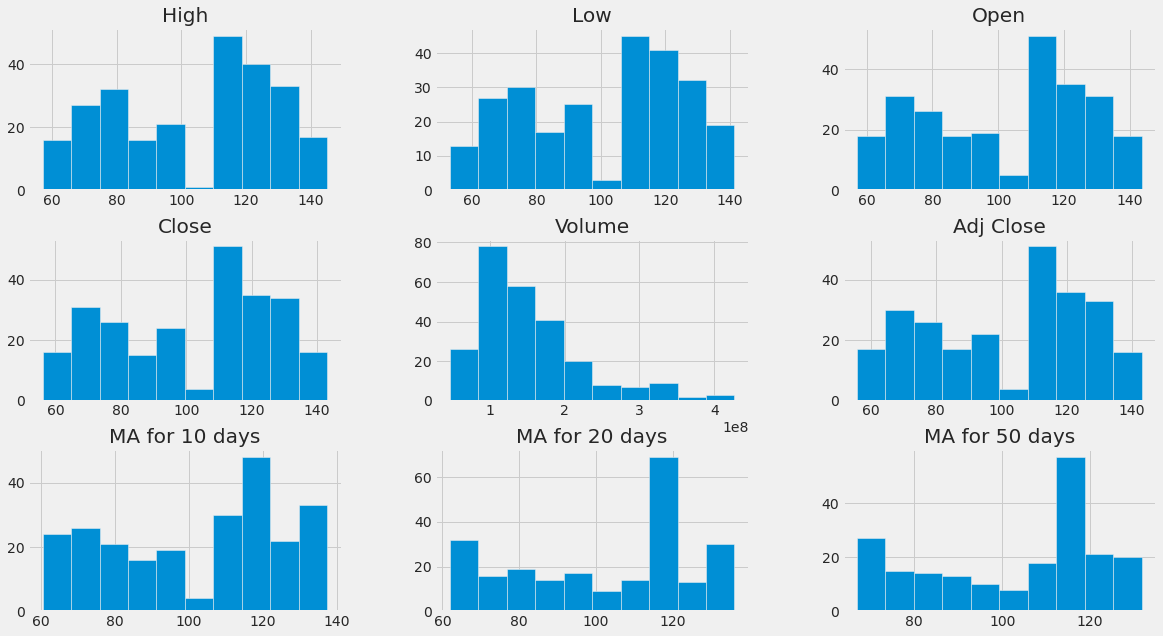

In [ ]:
AAPL.groupby("company_name").hist(figsize=(18, 10));

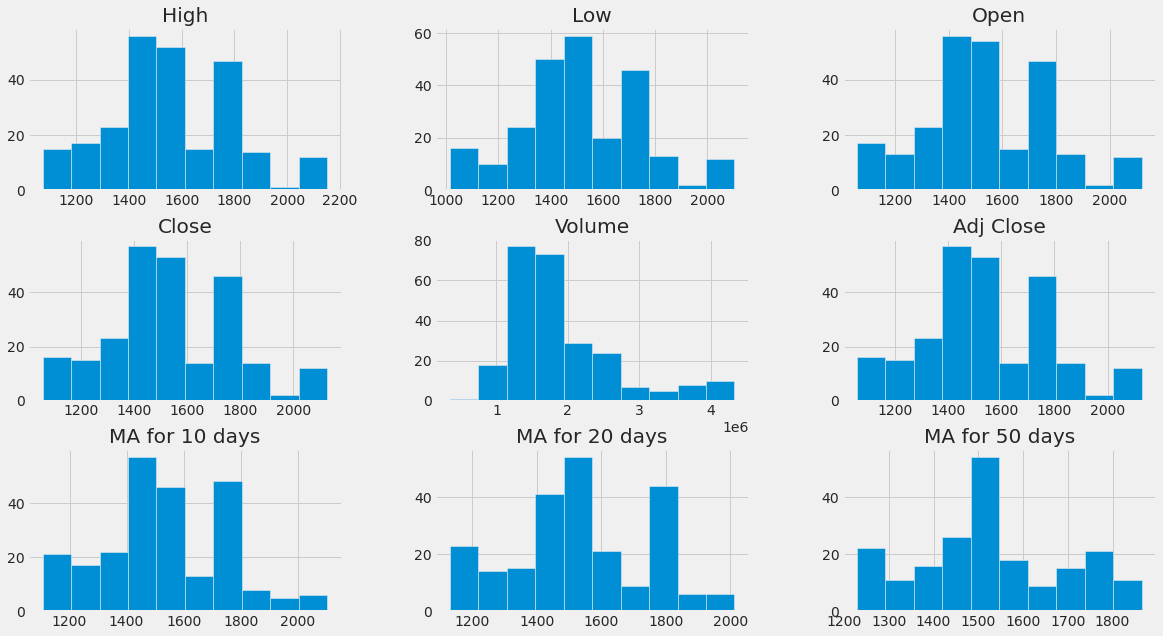

In [ ]:
GOOG.groupby("company_name").hist(figsize=(18, 10));

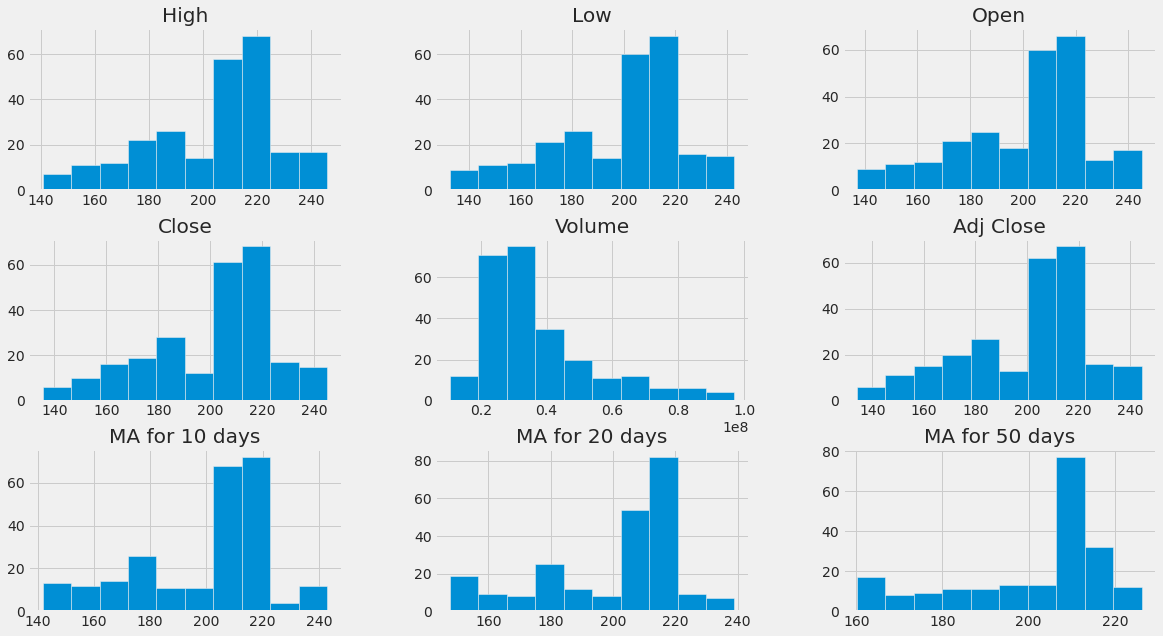

In [ ]:
MSFT.groupby("company_name").hist(figsize=(18, 10));

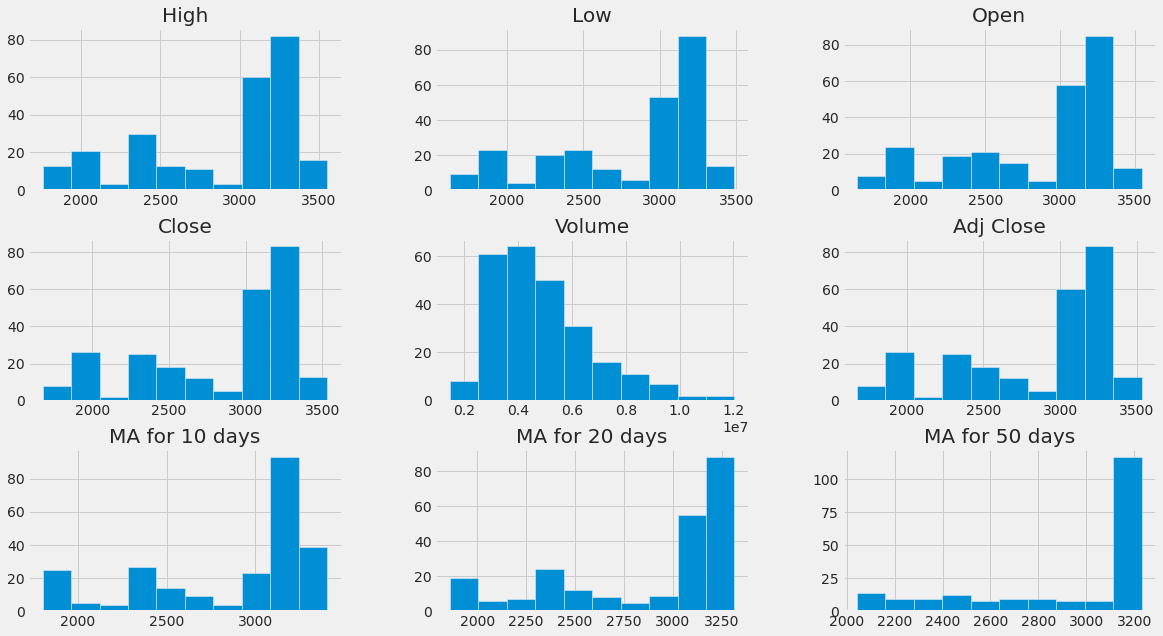

In [ ]:
AMZN.groupby("company_name").hist(figsize=(18, 10));

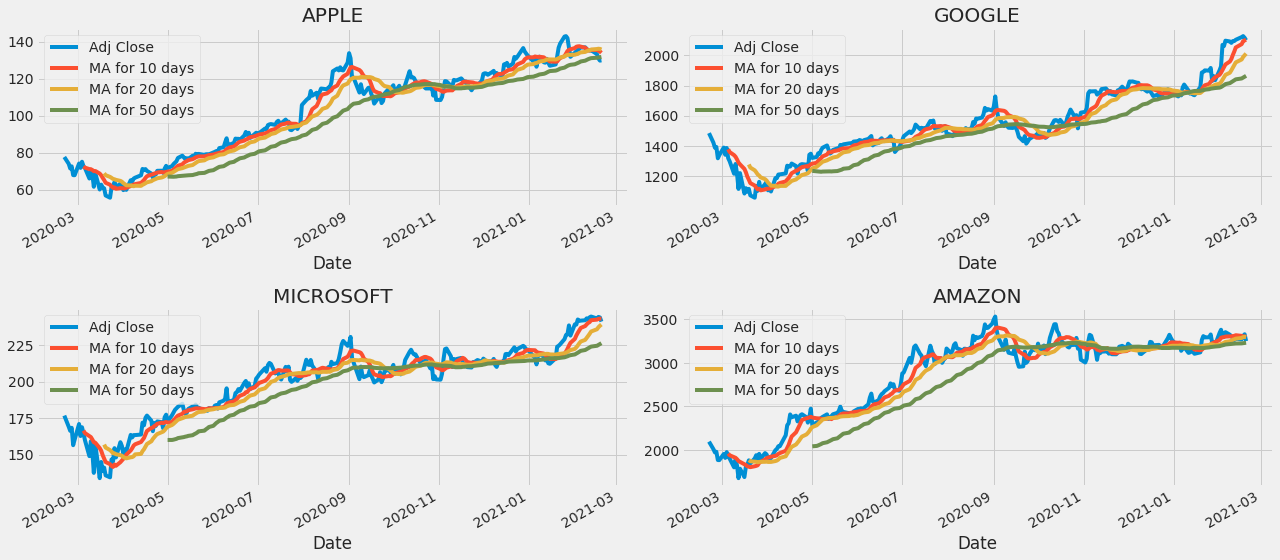

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(18)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[0,0])
ax[0,0].set_title('APPLE')
GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[0,1])
ax[0,1].set_title('GOOGLE')
MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[1,0])
ax[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax[1,1])
ax[1,1].set_title('AMAZON')

fig.tight_layout()

**The daily return of the stock on average :**

In [ ]:
# Here I have used **pct_change** to find the percentage change in each day

for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

In [ ]:
AAPL['Daily Return'].head()

Date
2020-02-21         NaN
2020-02-24   -0.047500
2020-02-25   -0.033872
2020-02-26    0.015864
2020-02-27   -0.065368
Name: Daily Return, dtype: float64

In [ ]:
GOOG['Daily Return'].head()

Date
2020-02-21         NaN
2020-02-24   -0.042771
2020-02-25   -0.023312
2020-02-26    0.003407
2020-02-27   -0.053898
Name: Daily Return, dtype: float64

In [ ]:
MSFT['Daily Return'].head()

Date
2020-02-21         NaN
2020-02-24   -0.043115
2020-02-25   -0.016502
2020-02-26    0.012495
2020-02-27   -0.070459
Name: Daily Return, dtype: float64

In [ ]:
AMZN['Daily Return'].head()

Date
2020-02-21         NaN
2020-02-24   -0.041356
2020-02-25   -0.018191
2020-02-26    0.003472
2020-02-27   -0.048136
Name: Daily Return, dtype: float64

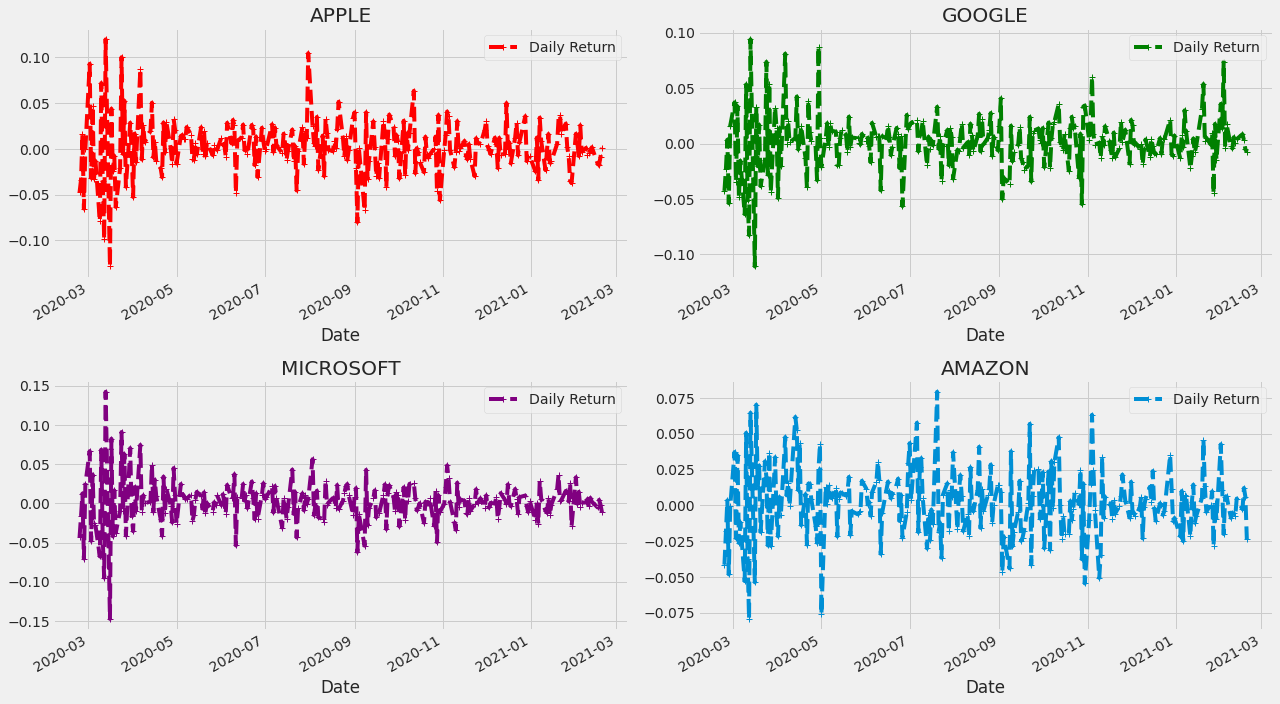

In [ ]:
# Ploting the daily return percentage
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(18)

AAPL['Daily Return'].plot(ax=ax[0,0], legend=True, linestyle='--', marker='+',color='red')
ax[0,0].set_title('APPLE')
GOOG['Daily Return'].plot(ax=ax[0,1], legend=True, linestyle='--', marker='+',color='green')
ax[0,1].set_title('GOOGLE')
MSFT['Daily Return'].plot(ax=ax[1,0], legend=True, linestyle='--', marker='+',color='purple')
ax[1,0].set_title('MICROSOFT')
AMZN['Daily Return'].plot(ax=ax[1,1], legend=True, linestyle='--', marker='+')
ax[1,1].set_title('AMAZON')
fig.tight_layout()

**Average daily return using a histogram :**

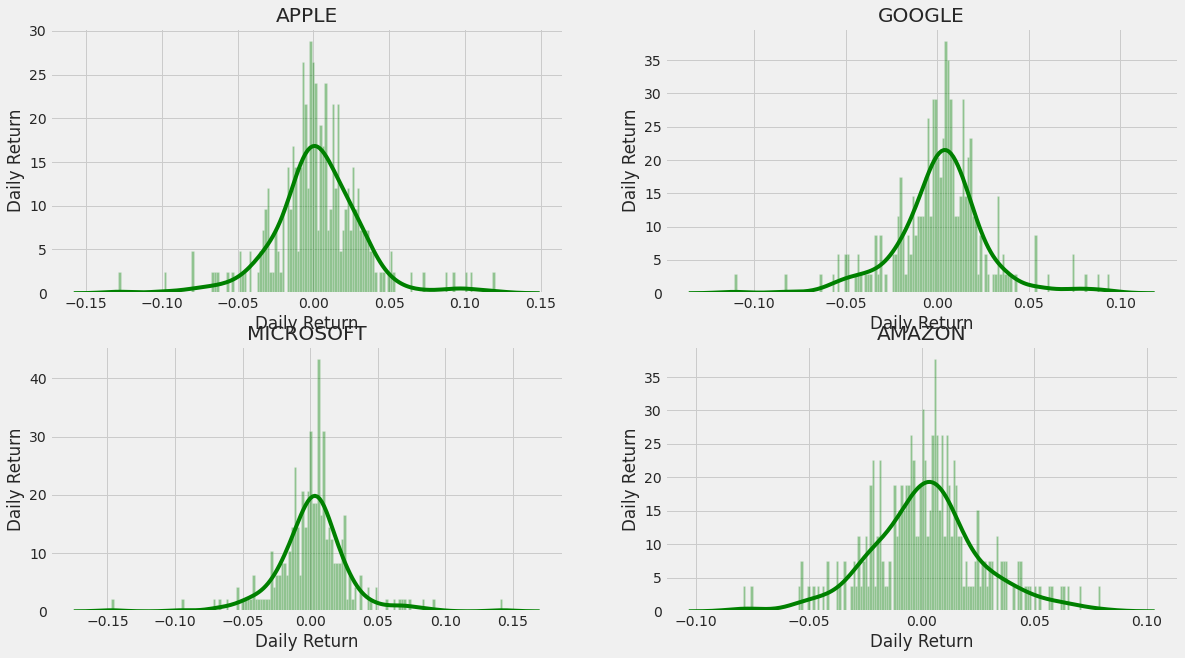

In [ ]:
# Note Here i am using of dropna() because dataset has some null values, otherwise the null values can't be read by seaborn

plt.figure(figsize=(18, 10))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=150, color='green')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')

**Is their any correlation between different stocks closing prices?**

In [ ]:
# Fetching all the closing prices for the companies stock list into a new DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']
closing_df.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-02-21,77.660507,1485.109985,176.793411,2095.969971
2020-02-24,73.971603,1421.589966,169.170883,2009.290039
2020-02-25,71.466019,1388.449951,166.379257,1972.739990
2020-02-26,72.599739,1393.180054,168.458115,1979.589966
2020-02-27,67.854019,1318.089966,156.588730,1884.300049


Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did earlier.

In [ ]:
#Creating new dataframe for returns on stock of our companies
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2020-02-21,NaN,NaN,NaN,NaN
2020-02-24,-0.047500,-0.042771,-0.043115,-0.041356
2020-02-25,-0.033872,-0.023312,-0.016502,-0.018191
2020-02-26,0.015864,0.003407,0.012495,0.003472
2020-02-27,-0.065368,-0.053898,-0.070459,-0.048136


**Comparing the daily percentage returns of two stocks :**

Now Here we can compare the daily percentage returns of two stocks to check how they correlated to each others.

*Firstly comparing GOOG stocks to itself:*

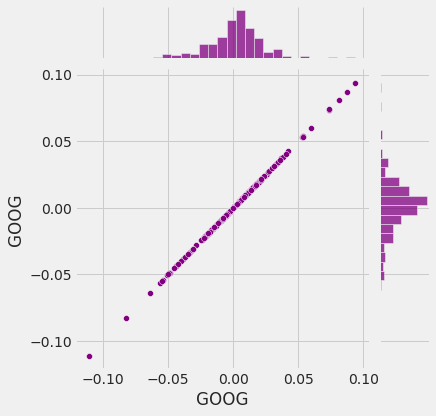

In [ ]:
sns.jointplot('GOOG', 'GOOG', tech_rets, kind='scatter', color='purple')

This graph show a perfectly linear relationship

**Now, its time to compare two stocks with each others :**

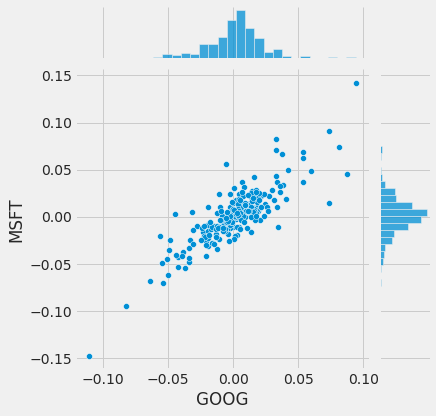

In [ ]:
# Comparing the daily returns of Google and Microsoft
sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')

Its good to see that both tech companies google and Microsft are posittively corelated to each other and a linear relationship bewteen its daily return values should occur.

So doing such a 12 combinations one by one is a lenghty tasks, for this Seaborn and pandas make it very easy for us to repeat this comparison analysis for every possible combination of stocks in our lists using a Pair Plot

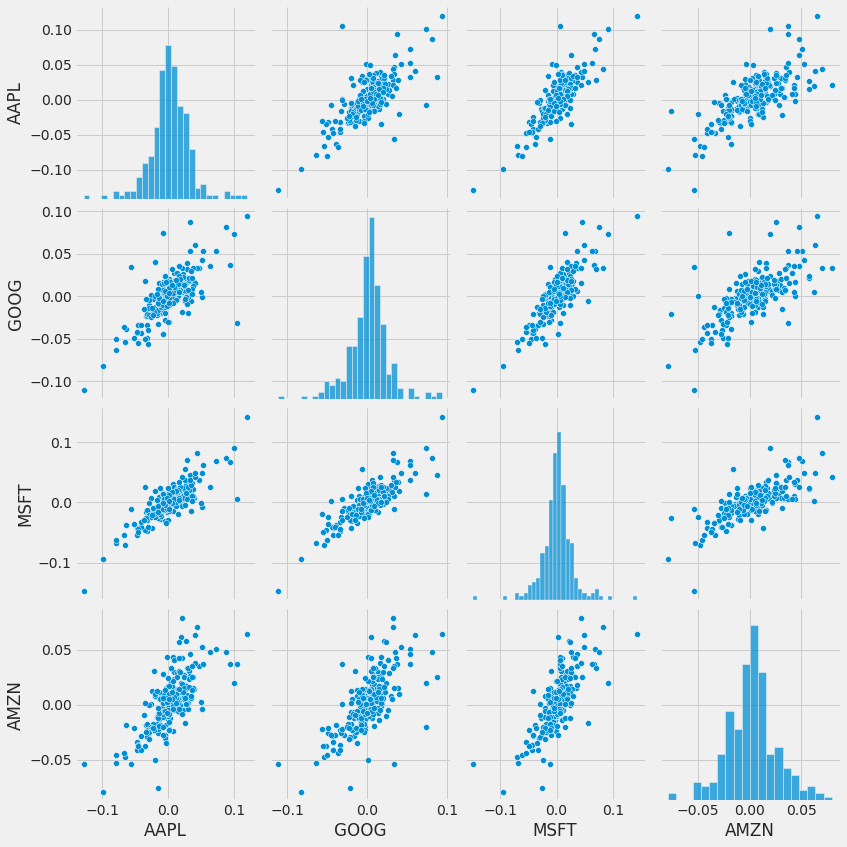

In [ ]:
sns.pairplot(tech_rets,palette="bright",diag_kind="auto",size=3)

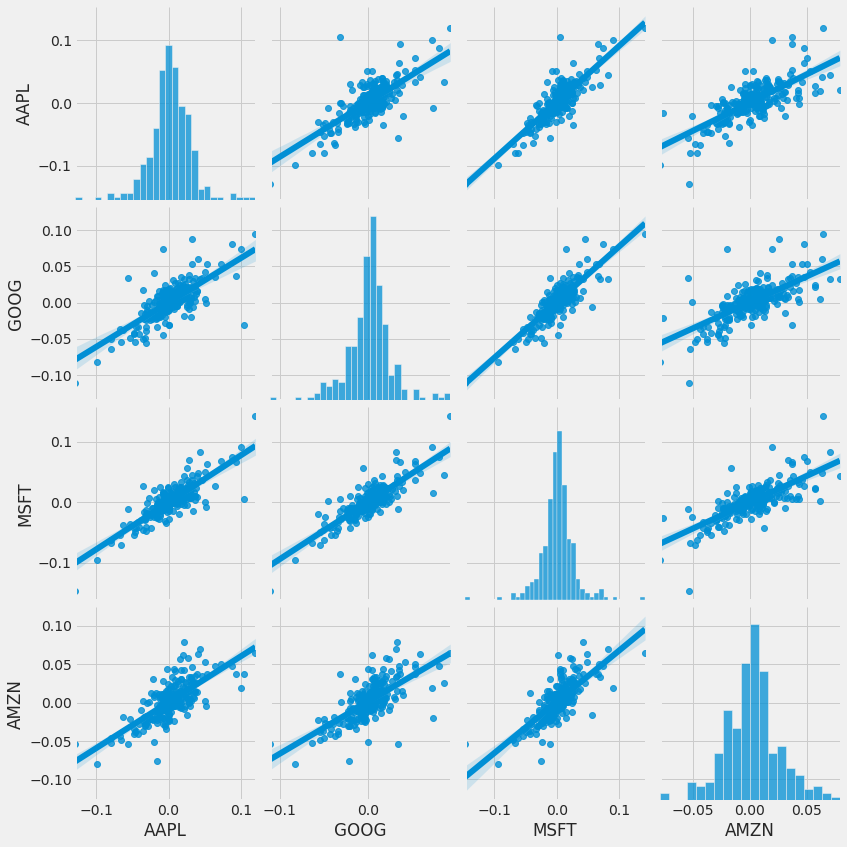

In [ ]:
# pairplot with regression line
sns.pairplot(tech_rets,palette="bright",kind="reg",diag_kind="auto",size=3)

A obeservation shows an interesting correlation between Google and Amazon and and Apple and Amazon daily returns.

**Plotting all possible comparison using pairGrid on stock returns :**

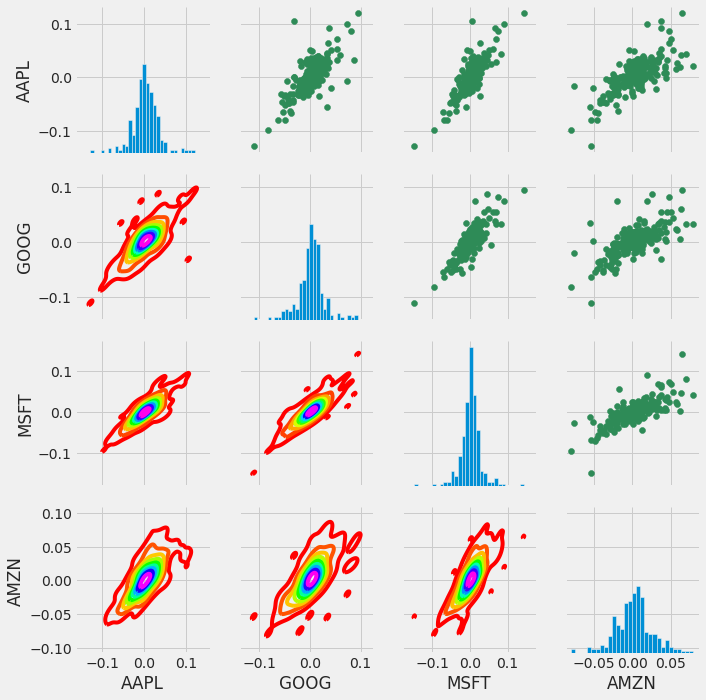

In [ ]:
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper to specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='seagreen')

# We can also define the lower triangle in the figure, including the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='hsv')

# The diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

**Plotting all possible comparison using pairGrid on Closing Price :**

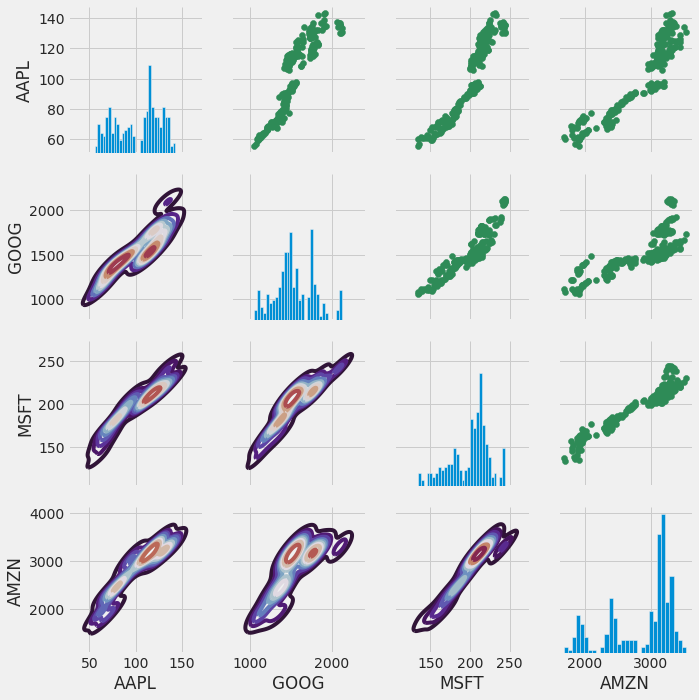

In [ ]:
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='seagreen')
returns_fig.map_lower(sns.kdeplot,cmap='twilight_shifted')
returns_fig.map_diag(plt.hist,bins=30)

A obeservation shows an interesting correlation between Apple and Microsoft and and Apple and Amazon closing price.

**Another way to see correlation using Heatmap :**

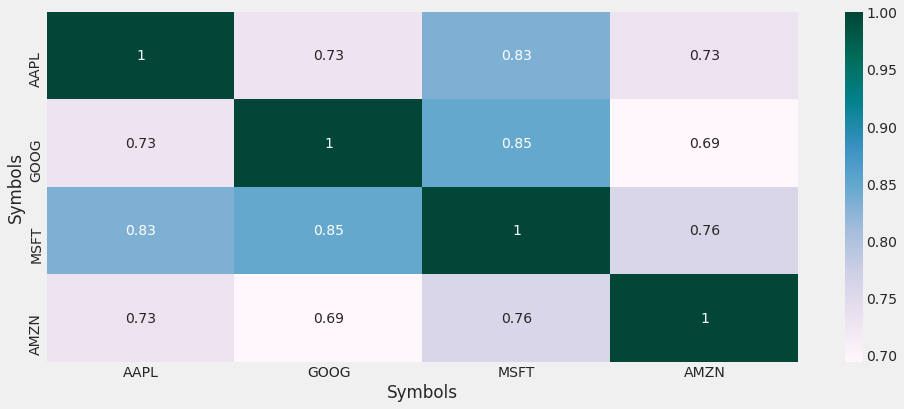

In [ ]:
# stock Returns
plt.figure(figsize=(15,6))
sns.heatmap(tech_rets.corr(), annot=True, cmap='PuBuGn')

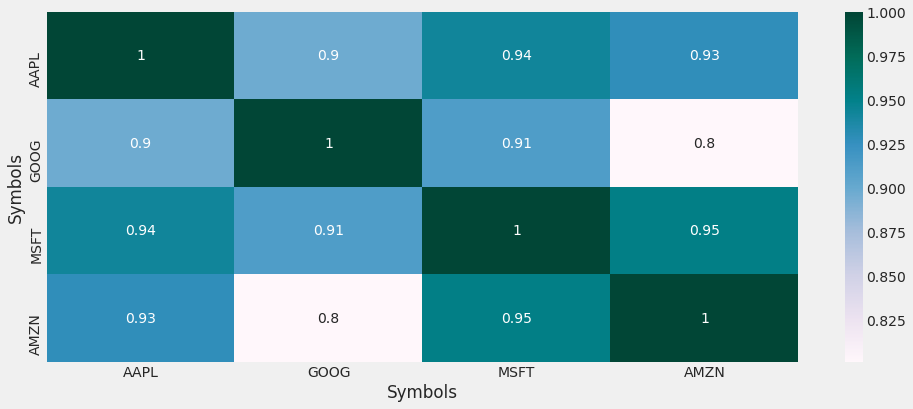

In [ ]:
# Closing Price
plt.figure(figsize=(15,6))
sns.heatmap(closing_df.corr(), annot=True, cmap='PuBuGn')

Its good to see that all the companies are positively correlated to each other and almost > 0.70

**How much value do we put at risk by investing in a particular stock?**

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

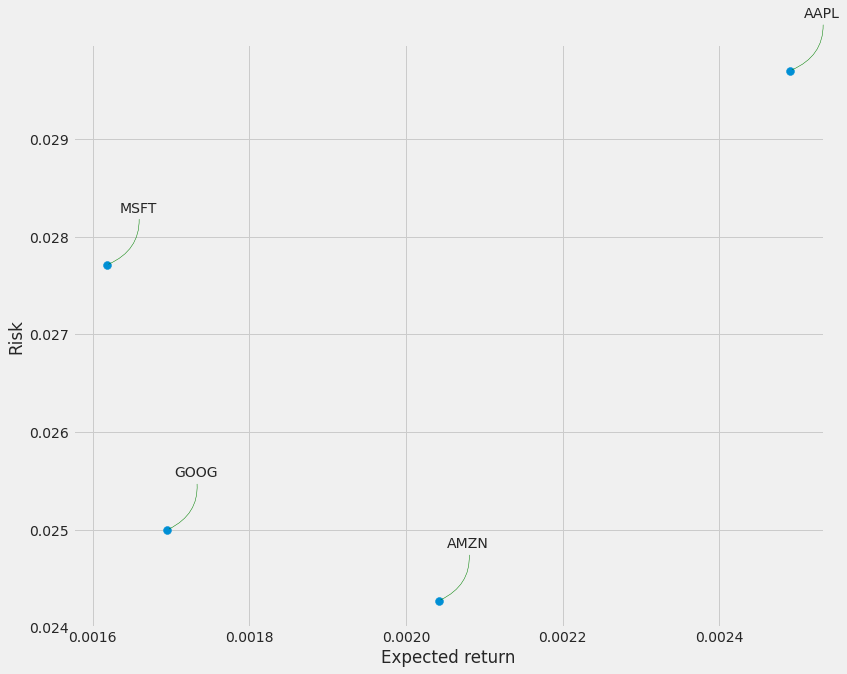

In [ ]:
# creating new DataFrame as a clenaed version of the oriignal tech_rets DataFrame
rets = tech_rets.dropna()

area = np.pi*20

plt.figure(figsize=(12, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='green', connectionstyle='arc3,rad=-0.4'))

In [ ]:
AAPL.head()

,High,Low,Open,Close,Volume,Adj Close,company_name,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,,
2020-02-21,80.112503,77.625000,79.654999,78.262497,129554000.0,77.660507,APPLE,NaN,NaN,NaN,NaN
2020-02-24,76.044998,72.307503,74.315002,74.544998,222195200.0,73.971603,APPLE,NaN,NaN,NaN,-0.047500
2020-02-25,75.632500,71.532501,75.237503,72.019997,230673600.0,71.466019,APPLE,NaN,NaN,NaN,-0.033872
2020-02-26,74.470001,71.625000,71.632500,73.162498,198054800.0,72.599739,APPLE,NaN,NaN,NaN,0.015864
2020-02-27,71.500000,68.239998,70.275002,68.379997,320605600.0,67.854019,APPLE,NaN,NaN,NaN,-0.065368


**Now, taking Amazon Stocks Data for analysis,**

In [ ]:
amz_df = DataReader('AMZN', data_source='yahoo', start='2001-01-01', end=datetime.now())
amz_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-02,16.0000,13.6250,15.8125,13.8750,9203500,13.8750
2001-01-03,17.8750,13.5625,13.6250,17.5625,14680400,17.5625
2001-01-04,17.5625,15.4375,17.0000,15.5000,10620500,15.5000
2001-01-05,15.8750,13.5625,15.5000,14.5625,8798800,14.5625
2001-01-08,15.5625,13.7500,14.4375,14.9375,10444700,14.9375


In [ ]:
amz_df.reset_index(inplace=True)
amz_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2001-01-02,16.0000,13.6250,15.8125,13.8750,9203500,13.8750
1,2001-01-03,17.8750,13.5625,13.6250,17.5625,14680400,17.5625
2,2001-01-04,17.5625,15.4375,17.0000,15.5000,10620500,15.5000
3,2001-01-05,15.8750,13.5625,15.5000,14.5625,8798800,14.5625
4,2001-01-08,15.5625,13.7500,14.4375,14.9375,10444700,14.9375


**Reading News Headlines data :**

In [ ]:
from google.colab import files 
uploaded = files.upload()                                                

Saving india-news-headlines.csv to india-news-headlines.csv


In [ ]:
news_headlines = pd.read_csv('india-news-headlines.csv')
# displaying news headlines dataset
news_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


**Feature Engineering of stock and news headline data :**

In [ ]:
# Identifying total numbers of records in both the datasets
print("Total records in Amazon Stocks Datasets: {}".format(len(amz_df)))
print("Total records in News Headline Datasets: {}".format(len(news_headlines)))

Total records in Amazon Stocks Datasets: 5065
Total records in News Headline Datasets: 3297172


In [ ]:
# checking for null values in both the datasets
print(amz_df.isna().any())
print(' ')
print(news_headlines.isna().any())

Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool
 
publish_date         False
headline_category    False
headline_text        False
dtype: bool


In [ ]:
amz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5065 entries, 0 to 5064
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5065 non-null   datetime64[ns]
 1   High       5065 non-null   float64       
 2   Low        5065 non-null   float64       
 3   Open       5065 non-null   float64       
 4   Close      5065 non-null   float64       
 5   Volume     5065 non-null   int64         
 6   Adj Close  5065 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 277.1 KB


In [ ]:
news_headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


**Data Pre-processing :**

Amazon Stock Price Data

In [ ]:

# dropping duplicates if any
amz_df = amz_df.drop_duplicates()

# Coverting the datatype of column 'Date' from  object to 'datetime'
amz_df['Date'] = pd.to_datetime(amz_df['Date']).dt.normalize()

# filtering the important columns required
amz_df = amz_df.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# Setting column 'Date' as the index column
amz_df.set_index('Date', inplace= True)

# Sorting the data according to Date
amz_df = amz_df.sort_index(ascending=True, axis=0)
amz_df

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,13.875000,15.812500,16.000000,13.625000,9203500
2001-01-03,17.562500,13.625000,17.875000,13.562500,14680400
2001-01-04,15.500000,17.000000,17.562500,15.437500,10620500
2001-01-05,14.562500,15.500000,15.875000,13.562500,8798800
2001-01-08,14.937500,14.437500,15.562500,13.750000,10444700
...,...,...,...,...,...
2021-02-12,3277.709961,3250.000000,3280.250000,3233.310059,2329300
2021-02-16,3268.949951,3254.050049,3308.300049,3253.590088,2563200
2021-02-17,3308.639893,3263.600098,3320.909912,3259.500000,3297500


News Headlines Data

In [ ]:
# dropping duplicates if any
news_headlines = news_headlines.drop_duplicates()

# Coverting the datatype of column 'Date' from  object to 'datetime'
news_headlines['publish_date'] = news_headlines['publish_date'].astype(str)
news_headlines['publish_date'] = news_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
news_headlines['publish_date'] = pd.to_datetime(news_headlines['publish_date']).dt.normalize()

# filtering the important columns required
news_headlines = news_headlines.filter(['publish_date', 'headline_text'])

# Grouping the news headlines according to 'Publish_Date'
news_headlines = news_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting column 'Date' as the index column
news_headlines.set_index('publish_date', inplace= True)

# Sorting the data according to Date
news_headlines = news_headlines.sort_index(ascending=True, axis=0)
news_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


**Data Merging**

In [ ]:
# concatenating the datasets stock_price and stock_headlines
stock_news_df = pd.concat([amz_df, news_headlines], axis=1)

# dropping the null values if any
stock_news_df.dropna(axis=0, inplace=True)

In [ ]:
# Take a quick glance on a dataset
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...
2001-01-08,14.9375,14.4375,15.5625,13.7500,10444700.0,"Sangh Parivar; Babri panel up the ante,Frontru..."


In [ ]:
stock_news_df.tail()

,Close,Open,High,Low,Volume,headline_text
2020-06-24,2734.399902,2780.000000,2796.000000,2721.000000,4526600.0,I never thought I had a voice until today: Vid...
2020-06-25,2754.580078,2739.550049,2756.229980,2712.139893,2968700.0,Truck firms look for new export markets to sel...
2020-06-26,2692.870117,2775.060059,2782.570068,2688.000000,6500800.0,Containment zone residents slam high prices ch...
2020-06-29,2680.379883,2690.010010,2696.800049,2630.080078,4223400.0,6 hot and stylish bikini looks of Katrina Kaif...
2020-06-30,2758.820068,2685.070068,2769.629883,2675.030029,3769700.0,"Detective Byomkesh Bakshy!,Edge of Tomorrow,Fi..."


**Sentiment Analysis**

In [ ]:
# importing requires libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# adding empty sentiment columns to stock_data for later calculation
stock_news_df['compound'] = ''
stock_news_df['negative'] = ''
stock_news_df['neutral'] = ''
stock_news_df['positive'] = ''
stock_news_df.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,13.8750,15.8125,16.0000,13.6250,9203500.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,17.5625,13.6250,17.8750,13.5625,14680400.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,15.5000,17.0000,17.5625,15.4375,10620500.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,14.5625,15.5000,15.8750,13.5625,8798800.0,Light combat craft takes India into club class...,,,,
2001-01-08,14.9375,14.4375,15.5625,13.7500,10444700.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [ ]:
# Instantiating the Sentiment Analyzer
sent_analyzer = SentimentIntensityAnalyzer()

**Finalising Stock Data and writing to Disk :**

In [ ]:
# dropping the 'headline_text' which is unwanted now
stock_news_df.drop(['headline_text'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_news_df = stock_news_df[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_news_df.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-01-02,13.8750,,,,,15.8125,16.0000,13.6250,9203500.0
2001-01-03,17.5625,,,,,13.6250,17.8750,13.5625,14680400.0
2001-01-04,15.5000,,,,,17.0000,17.5625,15.4375,10620500.0
2001-01-05,14.5625,,,,,15.5000,15.8750,13.5625,8798800.0
2001-01-08,14.9375,,,,,14.4375,15.5625,13.7500,10444700.0


In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving ^BSESN.csv to ^BSESN.csv


**Reading Stored Stock Data**

In [ ]:
stock_news_df = pd.read_csv('^BSESN.csv', index_col = False)

In [ ]:
stock_news_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-17,41324.039063,41420.339844,41030.578125,41055.691406,41055.691406,6900.0
1,2020-02-18,41042.460938,41042.460938,40610.949219,40894.378906,40894.378906,12300.0
2,2020-02-19,41121.511719,41357.160156,41048.929688,41323.000000,41323.000000,5600.0
3,2020-02-20,41334.960938,41399.929688,41134.308594,41170.121094,41170.121094,8400.0
4,2020-02-24,41037.011719,41037.011719,40306.359375,40363.230469,40363.230469,8100.0


In [ ]:
# renaming the column
stock_news_df.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_news_df.set_index('Date', inplace=True)

# Visualizing stock_data
stock_news_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-17,41324.039063,41420.339844,41030.578125,41055.691406,41055.691406,6900.0
2020-02-18,41042.460938,41042.460938,40610.949219,40894.378906,40894.378906,12300.0
2020-02-19,41121.511719,41357.160156,41048.929688,41323.000000,41323.000000,5600.0
2020-02-20,41334.960938,41399.929688,41134.308594,41170.121094,41170.121094,8400.0
2020-02-24,41037.011719,41037.011719,40306.359375,40363.230469,40363.230469,8100.0


**Feature Engineering of Stock News Data**

In [ ]:
stock_news_df.shape

(249, 6)

In [ ]:
# checking for null values
stock_news_df.isna().any()

Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool

In [ ]:
stock_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 2020-02-17 to 2021-02-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       246 non-null    float64
 1   High       246 non-null    float64
 2   Low        246 non-null    float64
 3   Close      246 non-null    float64
 4   Adj Close  246 non-null    float64
 5   Volume     246 non-null    float64
dtypes: float64(6)
memory usage: 13.6+ KB


In [ ]:
# Summary
stock_news_df.describe(include='all')

,Open,High,Low,Close,Adj Close,Volume
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,38905.045478,39195.754843,38489.227222,38851.665071,38851.665071,20398.780488
std,6055.606739,5973.607087,6142.680577,6088.337819,6088.337819,16247.927294
min,26499.810547,27462.869141,25638.900391,25981.240234,25981.240234,0.000000
25%,34244.863281,34558.888672,33951.600586,34217.800781,34217.800781,14625.000000
50%,38464.285157,38734.275390,38185.416015,38408.246094,38408.246094,18300.000000
75%,43297.164062,43538.533203,43032.581055,43421.547851,43421.547851,22200.000000
max,51907.750000,52235.968750,51886.460938,52154.128906,52154.128906,188300.000000


**Data Preparation of Stocks News Data :**

In [ ]:
# Preparing and Calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_news_df)-1))

# using 80% of data for training and 20% for testing
train_end = int(data_to_use*0.8)
total_data = len(stock_news_df)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 198
Number of records in Test Data: 51


In [ ]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
open_price = stock_news_df.iloc[start:total_data,0] #open
high = stock_news_df.iloc[start:total_data,1] #high
low = stock_news_df.iloc[start:total_data,2] #low
close_price = stock_news_df.iloc[start:total_data,3] #close
adj_close = stock_news_df.iloc[start:total_data,4] #Adj Close
volume = stock_news_df.iloc[start:total_data,5] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-02-18    40894.378906
2020-02-19    41323.000000
2020-02-20    41170.121094
2020-02-24    40363.230469
2020-02-25    40281.199219
                  ...     
2021-02-09    51329.078125
2021-02-10    51309.390625
2021-02-11    51531.519531
2021-02-12    51544.300781
2021-02-15    52154.128906
Name: Close, Length: 248, dtype: float64

In [ ]:
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-02-18,40894.378906,41323.000000,41042.460938,41357.160156,12300.0,41042.460938,41042.460938,40610.949219
2020-02-19,41323.000000,41170.121094,41357.160156,41399.929688,5600.0,41121.511719,41357.160156,41048.929688
2020-02-20,41170.121094,40363.230469,41399.929688,41037.011719,8400.0,41334.960938,41399.929688,41134.308594
2020-02-24,40363.230469,40281.199219,41037.011719,40536.000000,8100.0,41037.011719,41037.011719,40306.359375
2020-02-25,40281.199219,39888.960938,40536.000000,40255.390625,7300.0,40497.718750,40536.000000,40220.589844
2020-02-26,39888.960938,39745.660156,40255.390625,39947.800781,9000.0,40194.890625,40255.390625,39760.390625
2020-02-27,39745.660156,38297.289063,39947.800781,39087.468750,9600.0,39947.800781,39947.800781,39423.269531
2020-02-28,38297.289063,38144.019531,39087.468750,39083.171875,12700.0,39087.468750,39087.468750,38219.968750
2020-03-02,38144.019531,38623.699219,39083.171875,38754.238281,13400.0,38910.949219,39083.171875,37785.988281


**Setting the Target Variable and the Feature Dataset :**

In [ ]:
# setting the target variable as the shifted close_price
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
y = data['close_price_shifted']

In [ ]:
x.shape,y.shape

((241, 7), (241,))

**Scaling the Target Variable and the Feature Dataset**

Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. Here a feature range of (-1,1) is used.

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[0.16677255, 0.11431479, 0.12172407, ..., 0.15808673, 0.11431479,
         0.16869971],
        [0.20030696, 0.1401384 , 0.12517697, ..., 0.16438185, 0.1401384 ,
         0.20288793],
        [0.18834604, 0.14364798, 0.09587761, ..., 0.18137962, 0.14364798,
         0.2095525 ],
        ...,
        [0.98162112, 0.97349525, 0.94804691, ..., 0.97938449, 0.97349525,
         0.96765226],
        [0.99900002, 0.98002624, 0.96517266, ..., 0.96425002, 0.98002624,
         0.99193555],
        [1.        , 0.99743312, 1.        , ..., 1.        , 0.99743312,
         1.        ]]), array([[ 1.72339818e-01],
        [ 1.60657584e-01],
        [ 9.89990761e-02],
        [ 9.27306622e-02],
        [ 6.27577932e-02],
        [ 5.18074710e-02],
        [-5.88697348e-02],
        [-7.05818185e-02],
        [-3.39271187e-02],
        [-5.02966340e-02],
        [-4.56254716e-02],
        [-1.13939542e-01],
        [-2.62312303e-01],
        [-2.57540249e-01],
        [-4.80615191e-01],
     

**Dividing the dataset into Training and Test**

Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (198, 7) and y: (198, 1)
Number of rows and columns in the Test set X: (42, 7) and y: (42, 1)


**Reshaping the Feature Dataset**

In [ ]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (198, 7, 1)
Shape of Test set X: (42, 7, 1)


**News_Stock Data Modelling :**

In [ ]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(0)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [ ]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
20/20 [==============================] - 6s 88ms/step - loss: 0.0844 - val_loss: 0.0593
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0102 - val_loss: 0.0041
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 8.4602e-04
Epoch 6/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 7/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 8/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 9/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/10
20/20 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0055


**Predictions**

In [ ]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:4]

Predictions:


array([[47459.41 ],
       [47242.508],
       [47748.098],
       [47661.32 ]], dtype=float32)

**Model Evaluation :-** 

In [ ]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

42/42 [==============================] - 0s 2ms/step - loss: 0.0177
Train Loss = 0.0058
Test Loss = 0.0177


In [ ]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 50183.6326


In [ ]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 50183.6326


**Plotting the Predictions against unseen data :-**

In [ ]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

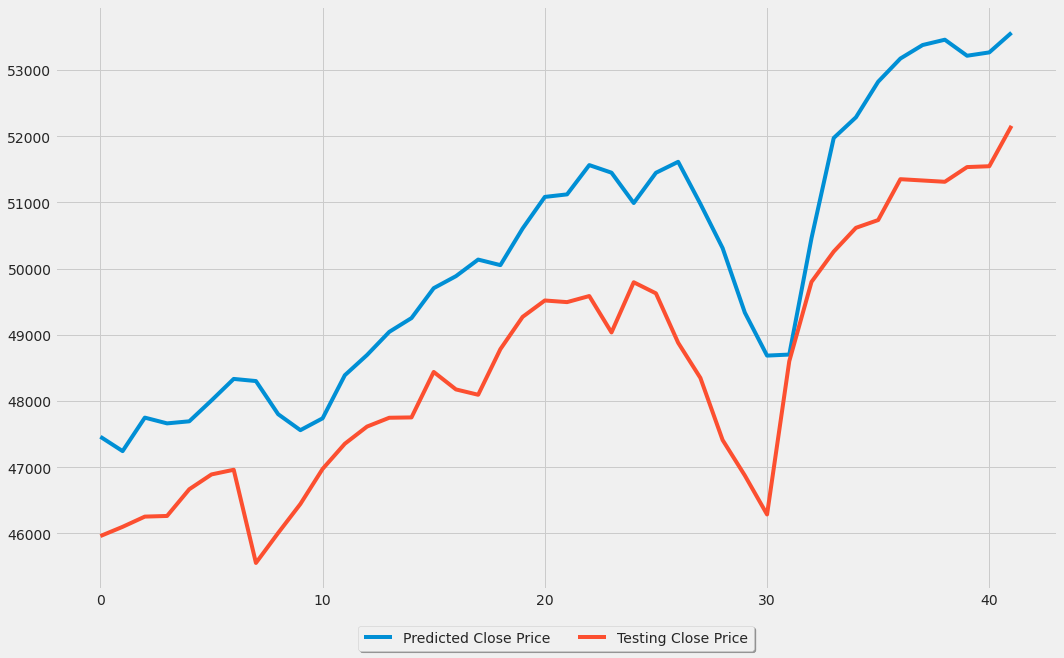

In [ ]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

**Conclusion :**

*I was successfully able to carry-out stock market predictionusing textual and numerical dataset using LSTM Algorithm was able to plot the predictions.*

# THANKS!